# Portafolios de Inversión
## Repaso Práctico
José Armando Melchor Soto

---





### Librerías 

In [77]:
import pandas as pd 
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize 

---

#### Funciones

##### Función Mínima Varianza 

In [78]:
def opt_min_var(rets):
    
    cov=rets.cov()
    n_assets = len(rets.columns)
    
    var = lambda w: w.T @ cov @ w
    
    w0=np.ones(n_assets)/n_assets
    
    bounds=[(0, 1)]*n_assets
    
    constraint=lambda w: sum(w)-1
    
    result=minimize(fun=var, x0=w0, bounds=bounds, constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)
    
    return result.x

##### Función Máximo de Sharpe

In [79]:
def opt_max_sharpe(rets, rf):
    
    E=rets.mean()
    cov=rets.cov()
    n_assets = len(rets.columns)
    
    rs = lambda w: -((w.T @ E - rf/252) / np.sqrt(w.T @ cov @ w))
    
    w0=np.ones(n_assets)/n_assets
    
    bounds=[(0, 1)]*n_assets
    
    constraint=lambda w: sum(w)-1
    
    result=minimize(fun=rs, x0=w0, bounds=bounds, constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)
    
    return result.x

##### Función Semi-Varianza Target

In [80]:
def objetivo (rets:pd.DataFrame , rets_b : pd.DataFrame ,corr:pd.DataFrame):
    
    rets, rets_b = rets.align(rets_b, join='inner', axis=0)
    diffs=rets - rets_b.values
    rends_below_bench = diffs[diffs < 0].fillna(0)
    target_downside_risk=np.array(rends_below_bench.std())
    target_semivarmatrix= corr * (target_downside_risk.reshape(len(rets.columns), 1) @ target_downside_risk.reshape(1, len(rets.columns)))

    objectivo = lambda w: (w.T @ target_semivarmatrix @ w)

    n = len(rets.keys())
    w_inicial = np.ones(n)/n
    bounds = [(0,1)]*n
    tol = 1e-9
    rest = lambda w: np.sum(w) - 1
    
    obj = minimize(
    fun=objectivo,
    x0=w_inicial,
    bounds=bounds,
    constraints={'fun': rest, 'type': 'eq'},
    tol=tol)

    w_objetivo = obj.x

    return dict(zip(rets.columns, w_objetivo))

#### Función de Backtesting

In [81]:
def backtesting(prices: pd.DataFrame, benchmark: pd.DataFrame, weights: dict, capital: float):
    
    # Obtener rendimientos de precios y benchmark
    rets_assets = prices.pct_change().dropna()
    rets_benchmark = benchmark.pct_change().dropna()
    
    # data frame vacio para llenar historia
    
    df = pd.DataFrame(index=rets_assets.index)
    
    # Obtener evolución para cada estrategia dada
    for strategy in weights.keys():
        # para benchmark
        if strategy == 'benchmark':
            temp = rets_benchmark + 1
            temp.iloc[0]=capital
            temp = temp.cumprod()
            df[strategy] = temp.values            
    
        # para otras estrategias

        else:
            temp = (rets_assets * weights.get(strategy)).sum(axis=1)+1
            temp.iloc[0]=capital
            temp = temp.cumprod()
            df[strategy] = temp.values    

    # Graficar la evolucion para ambos portafolios
    plt.figure(figsize=(12,6))
    plt.plot(df, label=df.keys())
    plt.title('Backtesting of Strategies')
    plt.xlabel('Date')
    plt.ylabel('Portafolio Value')
    plt.legend()
    plt.show()


    return df

##### Función Metricas de Desempeño

In [82]:
def metrics (history, rf):
    # Returns
    rets = history.pct_change().dropna()

    # Matriz Cov 
    cov = rets.cov()

    # Dataframe
    df = pd.DataFrame(index = rets.keys())

    # Rendimiento
    df['Rendimiento']=r_p = rets.mean() * 252 *100
    # Volatilidad
    df['Volatilidad']=vol = rets.std()* np.sqrt(252) *100

    # Ratio de Sharpe
    df['Ratio Sharpe'] = R_S = (r_p-rf)/vol 

    # Downside Risk
    df['Downside Risk'] = downside =  rets[rets < 0].std() 

    # Upside Risk
    df['Upside Risk'] = upside = rets[rets>0].std()

    # Omega
    df['Omega'] = omega = downside/upside
    # Beta
    covs = cov['Benchmark']
    varianza_market = covs['Benchmark']
    df['Beta'] = beta = covs/varianza_market
    # Alpha Jensen
    r_m = rets['Benchmark']

    df['Alpha Jensen'] =  r_p - (rf + beta * (r_m - rf))
    # Ratio de Traynor
    df['Ratio de Traynor'] = (r_p - rf)/beta
    # Ratio de Sortino
    df['Ratio de Sortino'] = (r_p - rf)/downside

    return df.T

---

#### Importación de Datos

In [83]:
tickers = ['LIVEPOLC-1.MX', 'KOFUBL.MX', 'CEMEXCPO.MX', 'CHDRAUIB.MX', 'CUERVO.MX', 'LABB.MX', 'RA.MX']

opt_prices = yf.download(tickers, start='2023-06-23', end='2024-06-23', progress=False)['Close']

bt_prices = yf.download(tickers,  start='2024-06-23', end='2025-06-23', progress=False)['Close']

benchmark = yf.download(['^MXX'], start='2024-06-23', end='2025-06-23', progress=False)['Close']

In [84]:
rets = opt_prices.pct_change().dropna()
rets_b = benchmark.pct_change().dropna()
corr = rets.corr()

---

#### Mínima Varianza 

In [85]:
w_minvar = opt_min_var(rets)
w_minvar

array([0.04611886, 0.30905644, 0.1171348 , 0.21646757, 0.00143756,
       0.24717856, 0.06260622])

#### Máximo de Sharpe

In [86]:
w_maxsharpe = opt_max_sharpe(rets,0.045)
w_maxsharpe

array([0.00000000e+00, 5.37796252e-01, 4.52042654e-17, 2.31370309e-18,
       9.00644650e-02, 3.72139283e-01, 0.00000000e+00])

#### Semi Varianza Target

In [87]:
w_semivar = objetivo(rets, rets_b, corr)
w_semivar

{'CEMEXCPO.MX': 0.14285714285714285,
 'CHDRAUIB.MX': 0.14285714285714285,
 'CUERVO.MX': 0.14285714285714285,
 'KOFUBL.MX': 0.14285714285714285,
 'LABB.MX': 0.14285714285714285,
 'LIVEPOLC-1.MX': 0.14285714285714285,
 'RA.MX': 0.14285714285714285}

#### Backtesting

In [88]:
capital = 1000000

In [89]:
w_dict = {
    'Min Varianza': w_minvar,
    'Max Sharpe': w_maxsharpe,
    'Semi-Varianza target': w_semivar,
    'Benchmark': 1
}

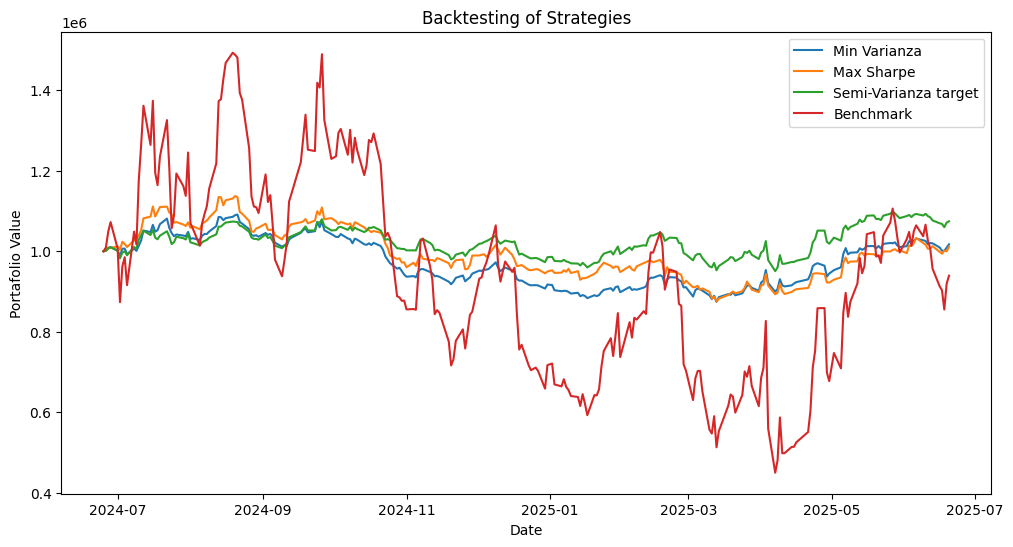

In [90]:
history = backtesting(bt_prices, benchmark, w_dict, capital)

In [91]:
metricas = metrics(history, 0.045)
metricas

,Min Varianza,Max Sharpe,Semi-Varianza target,Benchmark
Rendimiento,3.064643,2.787520,8.673200,60.712400
Volatilidad,16.298341,18.447184,16.368069,114.576480
Ratio Sharpe,0.185273,0.148669,0.527136,0.529493
Downside Risk,0.006459,0.007395,0.007222,0.050556
Upside Risk,0.006492,0.007477,0.006199,0.043392
Omega,0.995009,0.988958,1.165103,1.165103
Beta,0.126175,0.116057,0.142857,1.000000
Alpha Jensen,NaN,NaN,NaN,NaN
Ratio de Traynor,23.932208,23.630889,60.397400,60.667400
Ratio de Sortino,467.482714,370.870574,1194.651560,1199.992119


---

#### Con diferentes activos

In [92]:
tickers = ['LLY', 'ISRG', 'ABBV', 'JNJ', 'MRK']

In [93]:
opt_prices = yf.download(tickers, start='2023-06-23', end='2024-06-23', progress=False)['Close']

bt_prices = yf.download(tickers,  start='2024-06-23', end='2025-06-23', progress=False)['Close']

benchmark = yf.download(['VDC'], start='2024-06-23', end='2025-06-23', progress=False)['Close']

In [94]:
rets = opt_prices.pct_change().dropna()
rets_b = benchmark.pct_change().dropna()
corr = rets.corr()

---

#### Mínima Varianza 

In [95]:
w_minvar = opt_min_var(rets)

#### Máximo de Sharpe

In [96]:
w_maxsharpe = opt_max_sharpe(rets, 0.045)

#### Semi Varianza Target

In [97]:
w_semivar = objetivo(rets, rets_b, corr)

#### Backtesting

##### Capital

In [98]:
capital = 1000000

In [99]:
w_dict= {
    'Min Var' : w_minvar,
    'Max Sharpe': w_maxsharpe,
    'Semi Var': w_semivar,
    'Benchmark': 1
}

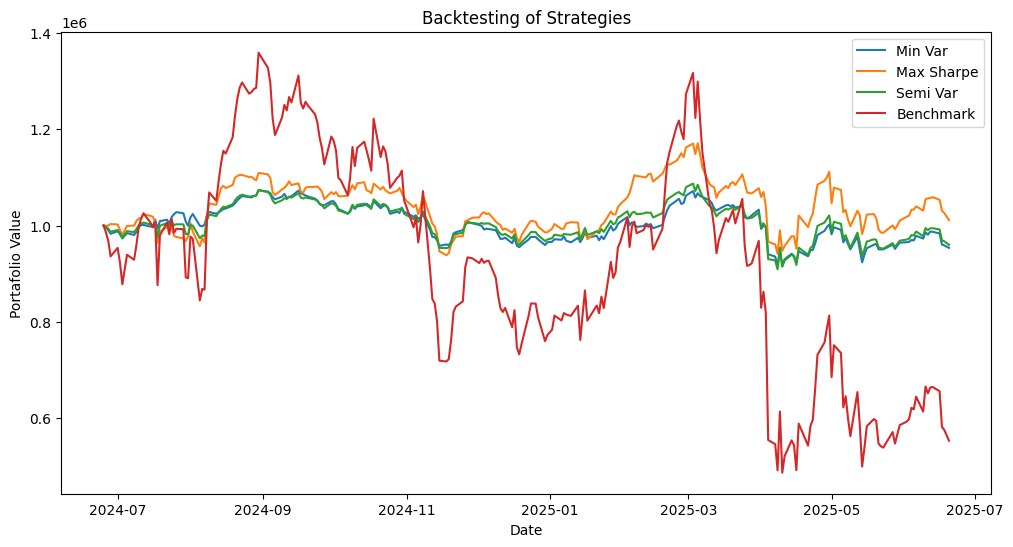

In [100]:
history = backtesting(bt_prices,benchmark, w_dict, capital )

In [101]:
metrics(history, rf= 0.045)


,Min Var,Max Sharpe,Semi Var,Benchmark
Rendimiento,-3.311045,4.585959,-2.298109,-11.490545
Volatilidad,17.604897,26.242554,19.474770,97.373850
Ratio Sharpe,-0.190631,0.173038,-0.120315,-0.118467
Downside Risk,0.008921,0.012619,0.009565,0.047823
Upside Risk,0.006256,0.010918,0.007896,0.039479
Omega,1.425981,1.155744,1.211365,1.211365
Beta,0.171365,0.248053,0.200000,1.000000
Alpha Jensen,NaN,NaN,NaN,NaN
Ratio de Traynor,-19.584222,18.306374,-11.715545,-11.535545
Ratio de Sortino,-376.211410,359.851893,-244.977447,-241.213564
